# Задание-1

В ноутбуке про многоруких бандитов мы разбирали классы для реализации отдельных стратегий решения задачки. Реализуйте в той же парадигме стратегии [exp3](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) и [softmax](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html) стратегии. Да, вы не ошиблись, они уже сделаны, надо понять, как оно работает и сделать так, чтобы оно работало в использованной нами конфигурации)

In [2]:
import time
import numpy as np
from scipy.stats import beta

# Общий класс для Бернуллиевских бандитов
class BernoulliBandit():

    def __init__(self, n, probas=None):
        assert probas is None or len(probas) == n
        
        # Кол-во ручек
        self.n = n
        
        if probas is None:
            np.random.seed(int(time.time()))
            # Истинные вероятности ручек (случайно заданные)
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            # Истинные вероятности ручек, если заданы в функции
            self.probas = probas

        # Вероятность оптимальной ручки
        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        # Генерация "выигрыша" для i-той ручки бандита
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

In [3]:
class Solver():    
    def __init__(self, bandit):
        """
        bandit (Bandit): Инициализация бандита.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # Список id ручек от 0 до bandit.n-1.
        self.regret = 0.  # Суммарная ошибка.
        self.regrets = [0.]  # История суммарной ошибки.

    def update_regret(self, i):
        # i (int): Индекс выбранной ручки.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    # Dummy-метод оценки вероятностей (переопределяется для каждого solver'a)    
    @property
    def estimated_probas(self):
        raise NotImplementedError
    
    # Dummy-метод перехода на следующий шаг (переопределяется для каждого solver'a)   
    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    # Запуск работы бандита на num_steps шагов
    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)

In [4]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, init_proba=1.0):
        """
        eps (float): Вероятность исследования случайной ручки.
        init_proba (float): начальное значение =  1.0;
        """
        # Сделали бандита
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        # Задали epsilon
        self.eps = eps
        
        self.estimates = [init_proba] * self.bandit.n  # Optimistic initialization

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Дернули случайную ручку
            i = np.random.randint(0, self.bandit.n)
        else:
            # Выбрали наилучшую (на данный момент) ручку
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        
        # Оценка для i-того бандита обновляется
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i
    
# UCB1 стратегия
class UCB1(Solver):
    def __init__(self, bandit, init_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [init_proba] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1

        # Выбрать лучшую ручку с учетом UCB.
        i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + np.sqrt(
            2 * np.log(self.t) / (1 + self.counts[x])))
        r = self.bandit.generate_reward(i)

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

# Байесовская UCB стратегия
class BayesianUCB(Solver):
    """Предположим априорное Бета-распределение."""

    def __init__(self, bandit, c=2, init_a=1, init_b=1):
        """
        c (float): Сколько стандартных отклонений рассматривать в качестве UCB.
        init_a (int): Исходное значение a в Beta(a, b).
        init_b (int): Исходное значение b в Beta(a, b).
        """
        super(BayesianUCB, self).__init__(bandit)
        self.c = c
        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / float(self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        # Выбрать лучшую ручку с учетом UCB.
        i = max(
            range(self.bandit.n),
            key=lambda x: self._as[x] / float(self._as[x] + self._bs[x]) +\
            beta.std(self._as[x], self._bs[x]) * self.c
        )
        r = self.bandit.generate_reward(i)

        # Обновление апостериорного бета-распределения
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

# Сэмплирование Томпсона
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): Исходное значение a в Beta(a, b).
        init_b (int): Исходное значение b в Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)

        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

In [5]:
from numpy.random import choice
import math

class Exp3(Solver):
    def __init__(self, bandit, gamma: 0.0):
        assert 0. <= gamma <= 1.0
        super(Exp3, self).__init__(bandit)
        # инициализируем веса
        self.weights = [1.] * self.bandit.n
        # инициализируем гамму
        self.gamma = gamma

        self.estimates = [0] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        # сумма весов
        weights_sum = float(sum(self.weights))
        # вычисляем распределение вероятностей
        probability_distribution = [(1.0 - self.gamma) * (w / weights_sum) + (self.gamma / len(self.weights)) for w in self.weights]
        # получаем индекс бандита 
        i = choice(a = self.bandit.n, p = probability_distribution, replace = False)
        # дергаем i-ую ручку
        reward = self.bandit.generate_reward(i)
        # обновляем веса
        self.weights[i] *= math.exp((reward / probability_distribution[i]) * self.gamma / self.bandit.n)

        self.estimates[i] += 1. / (self.counts[i] + 1) * (reward - self.estimates[i])

        return i

class SoftMax(Solver):
    def __init__(self, bandit, tau):
        assert 0. <= tau <= 1.0
        super(SoftMax, self).__init__(bandit)
        # инициализируем тау (температура), влияние прошлых данных на анализ
        self.tau = tau

        self.estimates = [0.0] * self.bandit.n
    
    @property
    def estimated_probas(self):
        return self.estimates
    
    def run_one_step(self):
        # вычислим знаменатель
        denominator = sum([math.exp(value / self.tau) for value in self.estimates])
        # вычисляем распределение вероятностей
        probability_distribution = [math.exp(value / self.tau) / denominator for value in self.estimates]
        # получаем индекс бандита 
        i = choice(a = self.bandit.n, p = probability_distribution, replace = False)
        # дергаем i-ую ручку
        reward = self.bandit.generate_reward(i)

        self.estimates[i] = (self.estimates[i] * (self.counts[i]) + reward)/ (self.counts[i] + 1)

        return i

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def plot_results(solvers, solver_names):
    """
    Отрисовка результатов различных стратегий для бандитов.
    Args:
        solvers (list<Solver>): Список решений проблемы бандитов, которые нужно подгонять.
        solver_names (list<str)
    """
    assert len(solvers) == len(solver_names)
    assert all(map(lambda s: isinstance(s, Solver), solvers))
    assert all(map(lambda s: len(s.regrets) > 0, solvers))

    b = solvers[0].bandit

    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)

    # Рисунок. 1: Зависимость ошибки от времени.
    for i, s in enumerate(solvers):
        ax1.plot(range(len(s.regrets)), s.regrets, label=solver_names[i])

    ax1.set_xlabel('Время')
    ax1.set_ylabel('Накопленная ошибка')
    ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)

    # Рисунок. 2: Вероятности, оцененные алгоритмами.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for s in solvers:
        ax2.plot(range(b.n), [s.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Ручки, отсортированные по ' + r'$\theta$')
    ax2.set_ylabel('Оцененная алгоритмом '+ r'$\hat\theta$')
    ax2.grid('k', ls='--', alpha=0.3)

    # Рисунок 3: Срабатывание ручек
    for s in solvers:
        ax3.plot(range(b.n), np.array(s.counts) / float(len(solvers[0].regrets)), ds='steps', lw=2)
    ax3.set_xlabel('Ручки')
    ax3.set_ylabel('Доля каждой ручки в общем кол-ве действий')
    ax3.grid('k', ls='--', alpha=0.3)

    plt.show()

In [11]:
def experiment(K, N):
    """
    Прогонка эксперимента с бернуллиевским бандитом с K руками,
    в каждой из которых случайно задается вероятность выигрыша.
    Args:
        K (int): Кол-во ручек.
        N (int): Кол-во испытаний.
        test_solvers: Список моделей решения задачи о Бандите(эпсилон-жадная, UCB и тд)
        names: Список названий стратегий для графиков
    """

    b = BernoulliBandit(K, probas = None)
    print("Истинные вероятности выигрыша у Бернуллиевского бандита:\n", b.probas)
    print("У лучшей ручки индекс: {} и вероятность: {}".format(
        max(range(K), key=lambda i: b.probas[i]), max(b.probas)))
    
    test_solvers = [
        # EpsilonGreedy(b, 0),
        # EpsilonGreedy(b, 0.01),
        EpsilonGreedy(b, 1),
        # BayesianUCB(b, 2, 1, 1),
        ThompsonSampling(b, 1, 1),
        Exp3(b, 0.7),
        SoftMax(b, 0.2)
    ]
    names = [
        # 'Full-exploitation',
        'Full-exploration',
#         r'$\epsilon$' + '-Greedy',
        # 'UCB1',
        # 'Bayesian UCB',
        'Thompson Sampling',
        'Exp3',
        'SoftMax'
    ]

    for s in test_solvers:
        s.run(N)

    plot_results(test_solvers, names)

Истинные вероятности выигрыша у Бернуллиевского бандита:
 [0.1102803584356884, 0.4406597144753811, 0.5610466686814508, 0.7084134654651295, 0.35827016045957694, 0.9793505741093306, 0.7257266364336803, 0.14845486544693098, 0.37793799194988487, 0.6674225424925702]
У лучшей ручки индекс: 5 и вероятность: 0.9793505741093306


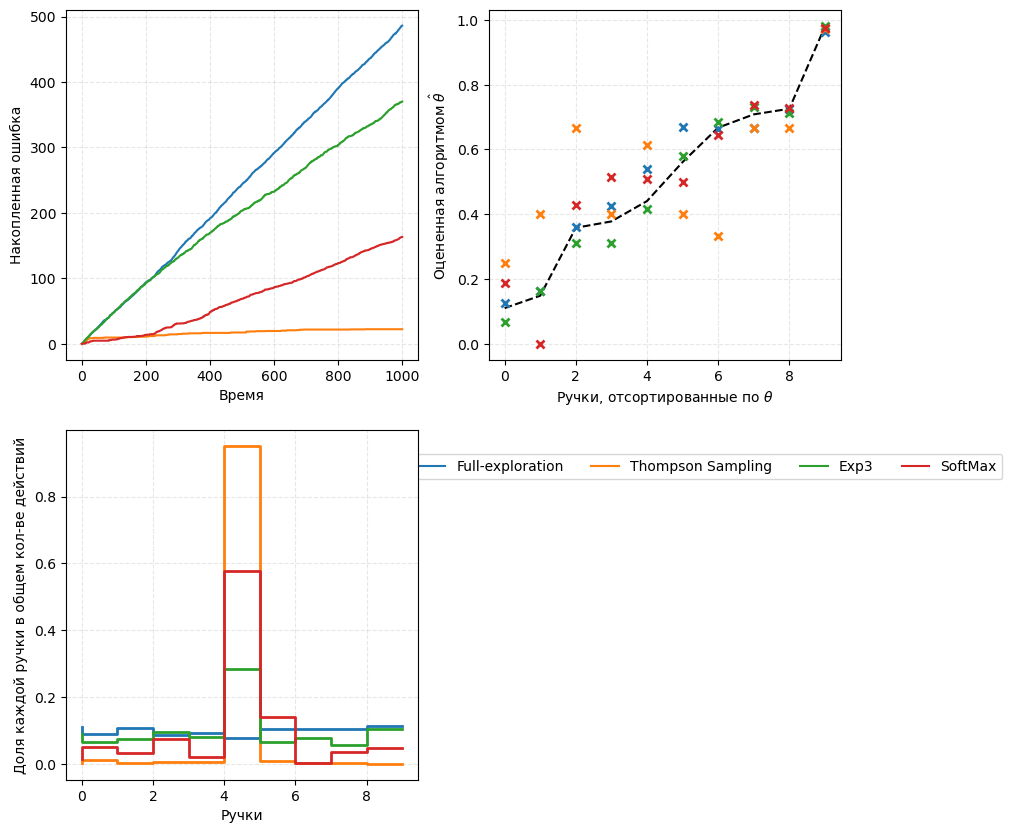

In [12]:
experiment(10,1000)

# Задание 2

В ДЗ по ML вы уже реализовали классы для того, чтобы делать логистические регрессии. Релизуйте класс, который будет из этих регрессий собирать полносвязный перцептрон из 2 слоев с 2 нейронами каждый и третьего выходного слоя. В качестве функции активации используйте сигмоиду, как в логистической регрессии. Если сделаете возможность в качестве активации выбирать ReLu и tanh в дополнение к сигмоиде, будете большими молодцами. Если можно будет задавать количество слоев и количество нейронов в слое, будете вдвойне молодцами) (но базовое требование - два слоя по два нейрона кадлый + 1 выходной слой) 

[Пример](https://github.com/pileyan/ML-From-Scratch/blob/master/mlfromscratch/supervised_learning/multilayer_perceptron.py)

Да, вы снова не ошиблись! реализация уже есть! Но у нас же тут с Вами курс по ПИТОНУ, а не ML :D

Про перцептрон [раз](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron), [два](https://mlcourse.at.ispras.ru/wp-content/uploads/2020/09/intro_to_nn_2020.pdf)

In [1]:
import numpy as np 
import math 

class Loss: 
    def loss(self, y_true, y_pred): 
        raise NotImplementedError 
 
    def gradient(self, y, y_pred): 
        raise NotImplementedError 
 
class ActivationFunction: 
    def __call__(self, x): 
        raise NotImplementedError 
 
    def gradient(self, x): 
        raise NotImplementedError 
 
class Sigmoid(ActivationFunction): 
    def __call__(self, x): 
        return 1 / (1 + np.exp(-x)) 
 
    def gradient(self, x): 
        return self.__call__(x) * (1 - self.__call__(x))
    
class Tanh(ActivationFunction): 
    def __call__(self, x):
        e = np.exp(1)
        return (e**x - e**(-x))/((e**x + e**(-x)))

    def gradient(self, x): 
        return self.__call__(x) * (1 - self.__call__(x))     
    
 
class ReLU(ActivationFunction): 
    def __call__(self, x): 
        return np.maximum(0, x) 
 
    def gradient(self, x): 
        return (x > 0).astype(int) 
 
class Softmax(ActivationFunction): 
    def __call__(self, x): 
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) 
        return e_x / e_x.sum(axis=-1, keepdims=True) 
 
    def gradient(self, x): 
        p = self.__call__(x) 
        return p * (1 - p) 
 
class CrossEntropy(Loss): 
    def loss(self, y, p): 
        p = np.clip(p, 1e-15, 1 - 1e-15) 
        return -y * np.log(p) - (1 - y) * np.log(1 - p) 
 
    def gradient(self, y, p): 
        p = np.clip(p, 1e-15, 1 - 1e-15) 
        return -(y / p) + (1 - y) / (1 - p)

In [2]:
class MultilayerPerceptron():
    """Multilayer Perceptron classifier. A fully-connected neural network with one hidden layer.
    Unrolled to display the whole forward and backward pass.

    Parameters:
    -----------
    n_hidden: int:
        The number of processing nodes (neurons) in the hidden layer.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_hidden_1, n_hidden_2, activation_function = ReLU(), n_iterations=3000, learning_rate=0.01):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.hidden_activation = activation_function
        self.output_activation = Softmax()
        self.loss = CrossEntropy()

    def _initialize_weights(self, X, y):
        n_samples, n_features = X.shape
        _, n_outputs = y.shape
        # Hidden layer
        limit   = 1 / math.sqrt(n_features)
        self.W  = np.random.uniform(-limit, limit, (n_features, self.n_hidden_1))
        self.w0 = np.zeros((1, self.n_hidden_1))

        limit   = 1 / math.sqrt(self.n_hidden_1)
        self.W1  = np.random.uniform(-limit, limit, (self.n_hidden_1, self.n_hidden_2))
        self.w01 = np.zeros((1, self.n_hidden_2))

        # Output layer
        limit   = 1 / math.sqrt(self.n_hidden_2)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden_2, n_outputs))
        self.v0 = np.zeros((1, n_outputs))

    def fit(self, X, y):

        self._initialize_weights(X, y)

        for i in range(self.n_iterations):

            # ..............
            #  Forward Pass
            # ..............

            # HIDDEN LAYER
            hidden_input = X.dot(self.W) + self.w0
            hidden_output = self.hidden_activation(hidden_input)

            hidden_input_1 = hidden_output.dot(self.W1) + self.w01
            hidden_output_1 = self.hidden_activation(hidden_input_1)
            # OUTPUT LAYER
            output_layer_input = hidden_output_1.dot(self.V) + self.v0
            y_pred = self.output_activation(output_layer_input)

            # ...............
            #  Backward Pass
            # ...............

            # OUTPUT LAYER
            # Grad. w.r.t input of output layer
            grad_wrt_out_l_input = self.loss.gradient(y, y_pred) * self.output_activation.gradient(output_layer_input)
            grad_v = hidden_output_1.T.dot(grad_wrt_out_l_input)
            grad_v0 = np.sum(grad_wrt_out_l_input, axis=0, keepdims=True)
            # HIDDEN LAYER
            # Grad. w.r.t input of hidden layer
            grad_wrt_hidden_l_input_1 = grad_wrt_out_l_input.dot(self.V.T) * self.hidden_activation.gradient(hidden_input_1)
            grad_w_1 = hidden_output.T.dot(grad_wrt_hidden_l_input_1)
            grad_w0_1 = np.sum(grad_wrt_hidden_l_input_1, axis=0, keepdims=True)

            grad_wrt_hidden_l_input = grad_wrt_hidden_l_input_1.dot(self.W1.T) * self.hidden_activation.gradient(hidden_input)
            grad_w = X.T.dot(grad_wrt_hidden_l_input)
            grad_w0 = np.sum(grad_wrt_hidden_l_input, axis=0, keepdims=True)

            # Update weights (by gradient descent)
            # Move against the gradient to minimize loss
            self.V  -= self.learning_rate * grad_v
            self.v0 -= self.learning_rate * grad_v0
            self.W1  -= self.learning_rate * grad_w_1
            self.w01 -= self.learning_rate * grad_w0_1
            self.W  -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0

    # Use the trained model to predict labels of X
    def predict(self, X):
        # Forward pass:
        hidden_input = X.dot(self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        hidden_input = hidden_output.dot(self.W1) + self.w01
        hidden_output = self.hidden_activation(hidden_input)
        output_layer_input = hidden_output.dot(self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)
        return y_pred
    

In [3]:
def to_categorical(x, num_classes=None): 
    """  
    One-hot encoding of nominal values. 
     
    Args: 
    x (array-like): Array-like input data (integer values). 
    num_classes (int, optional): Number of categories.  
                                 If None, it will be inferred from the input data. 
 
    Returns: 
    np.ndarray: One-hot encoded representation of the input. 
    """ 
    # If num_classes is not provided, infer it from the input data 
    if num_classes is None: 
        num_classes = np.max(x) + 1 
 
    # Initialize the one-hot encoded array with zeros 
    one_hot_encoded = np.zeros((len(x), num_classes)) 
 
    # Set the appropriate elements to 1 
    one_hot_encoded[np.arange(len(x)), x] = 1 
 
    return one_hot_encoded

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

data = datasets.load_wine()
X = data.data
y = data.target
y = to_categorical(y)
 
SS = StandardScaler()    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

clf = MultilayerPerceptron(
    n_hidden_1=32, 
    n_hidden_2=16, 
    activation_function= ReLU(), 
    n_iterations=10000, 
    learning_rate=0.01
)

clf.fit(
    X_train,
    y_train
)

y_pred = np.argmax(clf.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9861111111111112
